In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import numpy as onp

import haiku as hk
from jax.experimental import optix

from nsec.datasets.two_moons import get_two_moons
from nsec.utils import display_score_two_moons
from nsec.models.dae.ardae import ARDAE
from nsec.normalization import SNParamsTree as CustomSNParamsTree

from functools import partial

Populating the interactive namespace from numpy and matplotlib


##  Defining the analytic target distribution

/Users/br263581/opt/anaconda3/envs/cosmo/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


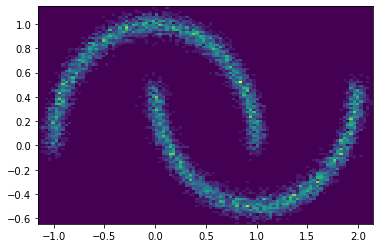

In [2]:
two_moons = get_two_moons(0.05)

rng_key = jax.random.PRNGKey(seed=0)
samps = two_moons.sample(10000, seed=rng_key)

# Plotting samples
hist2d(samps[:,0], samps[:,1],100);

In [3]:
# But now we can also compute the gradients of log p :-)
true_score = jax.vmap(jax.grad(two_moons.log_prob))

/Users/br263581/opt/anaconda3/envs/cosmo/lib/python3.7/site-packages/jax/numpy/lax_numpy.py:1601: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


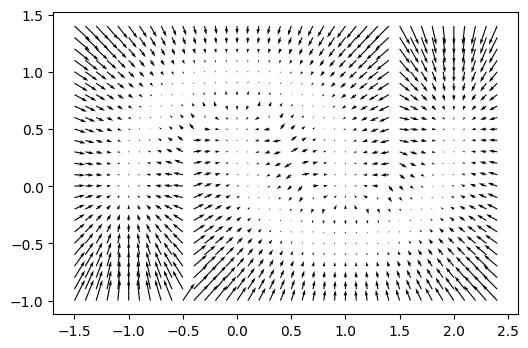

In [4]:
# Close up
figure(dpi=100)
X = np.arange(-1.5, 2.5, 0.1)
Y = np.arange(-1, 1.5, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
g = true_score(points).reshape([len(Y), len(X),2])

quiver(X, Y, g[:,:,0], g[:,:,1])

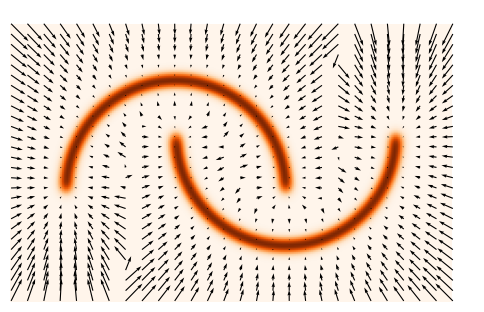

In [5]:
display_score_two_moons(true_score, two_moons, is_amortized=False, is_reg=False)

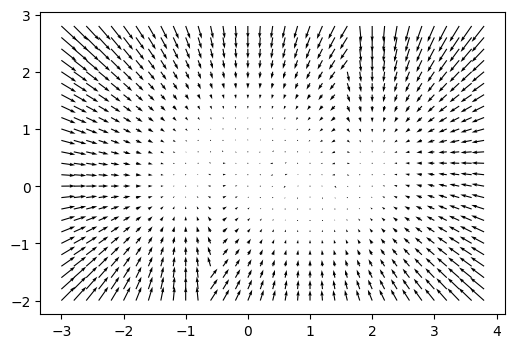

In [6]:
# Large scale
figure(dpi=100)
X = np.arange(-3, 4, 0.2)
Y = np.arange(-2, 3, 0.2)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
g = true_score(points).reshape([len(Y), len(X),2])

quiver(X, Y, g[:,:,0], g[:,:,1])

## Implementing AR-DAE 

```
class ARDAE(hk.Module):
    def __init__(self, is_training=False):
        super(ARDAE, self).__init__()
        self.is_training=is_training

    def __call__(self, x, sigma):
        sigma = sigma.reshape((-1,1))
        # Encoder
        net = hk.Linear(128)(jnp.concatenate([x, sigma],axis=1))
        net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(128)(net)
        net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(2)(net)

        # Decoder
        net = hk.Linear(128)(jnp.concatenate([net, sigma],axis=1))
        net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(128)(net)
        net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(2)(net)

        return net
```

In [7]:
def forward(x, sigma, is_training=False):
    denoiser = ARDAE(is_training=is_training)
    return denoiser(x, sigma)

model_train = hk.transform_with_state(partial(forward, is_training=True))


In [8]:
batch_size = 512
delta = 0.05

def get_batch(rng_key):
    y = two_moons.sample(batch_size, seed=rng_key)
    u = onp.random.randn(batch_size, 2)
    s = delta * onp.random.randn(batch_size, 1)
    x = y + s * u
    # x is a noisy sample, y is a sample from the distribution
    # u is the random normal noise realisation
    return {'x':x, 'y':y, 'u':u, 's':s}

In [9]:
optimizer = optix.adam(1e-3)
rng_seq = hk.PRNGSequence(42)

In [10]:
@jax.jit
def loss_fn(params, state, rng_key, batch):
    res, state = model_train.apply(params,  state, rng_key, 
                                   batch['x'], batch['s'])
    loss = jnp.mean((batch['u'] + batch['s'] * res)**2)
    return loss, state

In [11]:
@jax.jit
def update(params, state, rng_key, opt_state, batch):
    (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optix.apply_updates(params, updates)
    return loss, new_params, state, new_opt_state

In [12]:
params, state = model_train.init(next(rng_seq), 
                                 jnp.zeros((1, 2)), 
                                 jnp.ones((1, 1)))
opt_state = optimizer.init(params)
losses = []

In [13]:
for step in range(2000):
    batch = get_batch(next(rng_seq))
    loss, params, state, opt_state = update(params, state, next(rng_seq), opt_state, batch)
    losses.append(loss)
    if step%100==0:
        print(step, loss)

0 1.0628693
100 0.9522995
200 0.9008733
300 0.94795626
400 0.9311153
500 0.85929346
600 0.81830525
700 0.8787295
800 0.82683206
900 0.85249114
1000 0.8774686
1100 0.9007397
1200 0.83388186
1300 0.8290361
1400 0.8563056
1500 0.8525395
1600 0.9334577
1700 0.8705137
1800 0.871892
1900 0.85447955


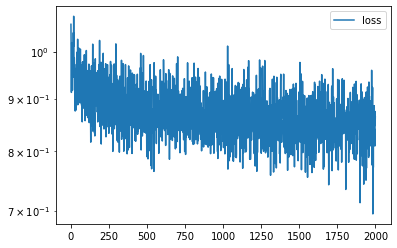

In [14]:
semilogy(np.array(losses[:]), label='loss')
legend()

In [15]:
X = np.arange(-1.5, 2.5, 0.1)
Y = np.arange(-1, 1.5, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

model = hk.transform_with_state(partial(forward, is_training=False))
dae_score = partial(model.apply, params, state, next(rng_seq))

In [16]:
res, state = dae_score(points, 0.0*jnp.ones((len(points),1)))

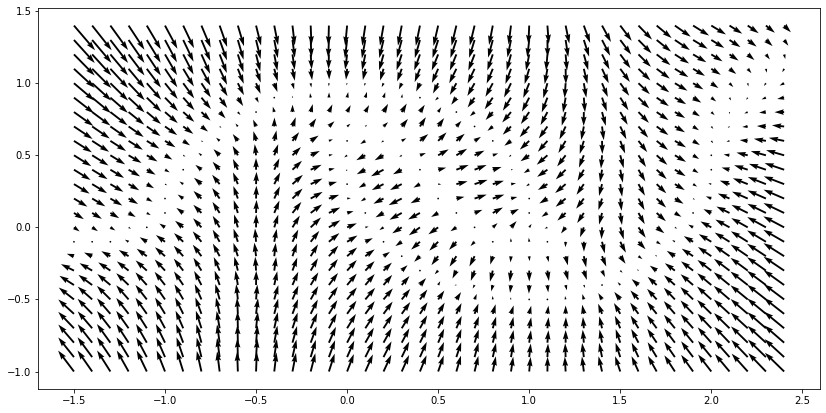

In [17]:
g = res.reshape([len(Y), len(X),2])
figure(figsize=(14,7))
quiver(X, Y, g[:,:,0], g[:,:,1])

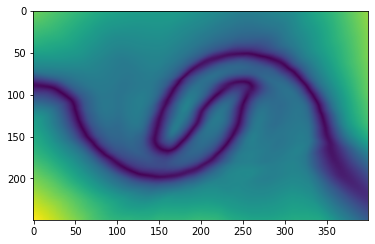

In [18]:
X = np.arange(-1.5, 2.5, 0.01)
Y = np.arange(-1, 1.5, 0.01)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
res, state = dae_score(points, jnp.zeros((len(points),1)))
g = res.reshape([len(Y), len(X),2])
imshow(np.sqrt(g[:,:,0]**2 + g[:,:,1]**2))

/Users/br263581/opt/anaconda3/envs/cosmo/lib/python3.7/site-packages/jax/numpy/lax_numpy.py:1601: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


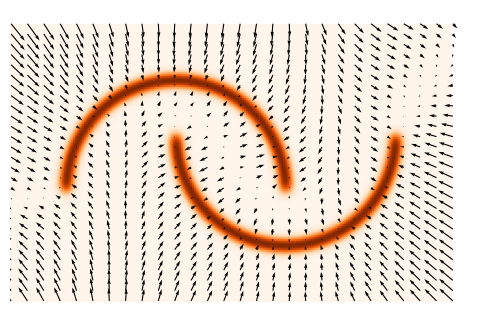

In [19]:
display_score_two_moons(dae_score, two_moons, is_amortized=True, is_reg=True)

In [20]:
X = np.arange(-3, 4, 0.2)
Y = np.arange(-2, 3, 0.2)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

res, state = dae_score(points, 0.0*jnp.ones((len(points),1)))

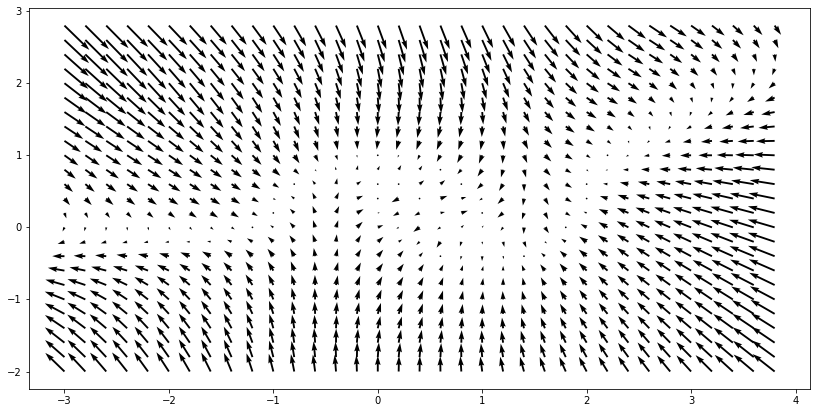

In [21]:
g = res.reshape([len(Y), len(X),2])
figure(figsize=(14,7))
quiver(X, Y, g[:,:,0], g[:,:,1])

## Adding Lipschitz regularisation

In [22]:
def forward(x, sigma, is_training=False):
    denoiser = ARDAE(is_training=is_training)
    return denoiser(x, sigma)

model_train = hk.transform_with_state(partial(forward, is_training=True))

sn_fn = hk.transform_with_state(lambda x: CustomSNParamsTree(ignore_regex='[^?!.]*b$')(x))

In [23]:
batch_size = 512
delta = 0.05

def get_batch(rng_key):
    y = two_moons.sample(batch_size, seed=rng_key)
    u = onp.random.randn(batch_size, 2)
    s = delta * onp.random.randn(batch_size, 1)
    x = y + s * u
    # x is a noisy sample, y is a sample from the distribution
    # u is the random normal noise realisation
    return {'x':x, 'y':y, 'u':u, 's':s}

In [24]:
optimizer = optix.adam(1e-3)
rng_seq = hk.PRNGSequence(42)

In [25]:
@jax.jit
def loss_fn(params, state, rng_key, batch):
    res, state = model_train.apply(params,  state, rng_key, 
                                   batch['x'], batch['s'])
    loss = jnp.mean((batch['u'] + batch['s'] * res)**2)
    return loss, state

In [26]:
@jax.jit
def update(params, state, sn_state, rng_key, opt_state, batch):
    (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optix.apply_updates(params, updates)
    
    new_params, new_sn_state = sn_fn.apply(None, sn_state, None, new_params)
    
    return loss, new_params, state, new_sn_state, new_opt_state

In [27]:
params, state = model_train.init(next(rng_seq), 
                                 jnp.zeros((1, 2)), 
                                 jnp.ones((1, 1)))
opt_state = optimizer.init(params)
_, sn_state = sn_fn.init(jax.random.PRNGKey(1), params)

losses = []

In [28]:
for step in range(2000):
    batch = get_batch(next(rng_seq))
    loss, params, state, sn_state, opt_state = update(params, state, sn_state, next(rng_seq), opt_state, batch)
    losses.append(loss)
    if step%100==0:
        print(step, loss)

0 0.97907275
100 0.98639417
200 0.9615811
300 0.9141171
400 0.9496142
500 0.8935486
600 0.9634085
700 0.8852756
800 0.9109726
900 0.937256
1000 0.93675864
1100 0.8851736
1200 0.8821657
1300 0.9619716
1400 0.88086057
1500 0.8908046
1600 0.8959352
1700 0.8760915
1800 0.8513269
1900 0.89082634


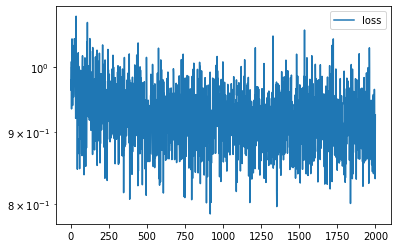

In [29]:
semilogy(np.array(losses[:]), label='loss')
legend()

In [30]:
X = np.arange(-1.5, 2.5, 0.1)
Y = np.arange(-1, 1.5, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

model_sn = hk.transform_with_state(partial(forward, is_training=False))
score_sn = partial(model_sn.apply, params, state, next(rng_seq))

In [31]:
res, state = score_sn(points, 0.0*jnp.ones((len(points),1)))

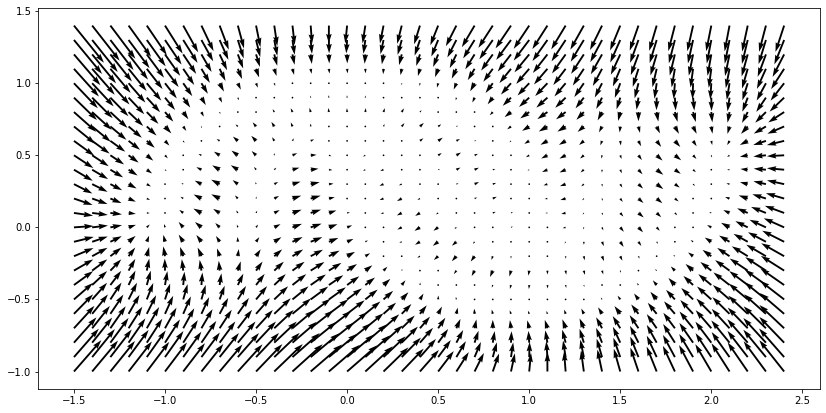

In [32]:
g = res.reshape([len(Y), len(X),2])
figure(figsize=(14,7))
quiver(X, Y, g[:,:,0], g[:,:,1])

/Users/br263581/opt/anaconda3/envs/cosmo/lib/python3.7/site-packages/jax/numpy/lax_numpy.py:1601: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


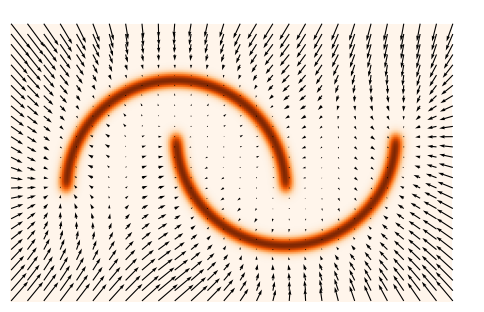

In [33]:
display_score_two_moons(score_sn, two_moons, is_amortized=True, is_reg=True)

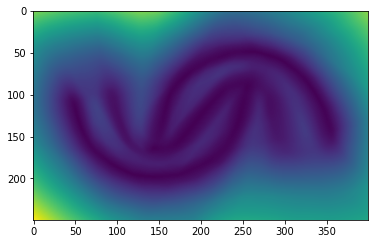

In [34]:
X = np.arange(-1.5, 2.5, 0.01)
Y = np.arange(-1, 1.5, 0.01)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
res, state = score_sn(points, jnp.zeros((len(points),1)))
g = res.reshape([len(Y), len(X),2])
imshow(np.sqrt(g[:,:,0]**2 + g[:,:,1]**2))

In [35]:
X = np.arange(-3, 4, 0.2)
Y = np.arange(-2, 3, 0.2)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

res, state = score_sn(points, 0.0*jnp.ones((len(points),1)))

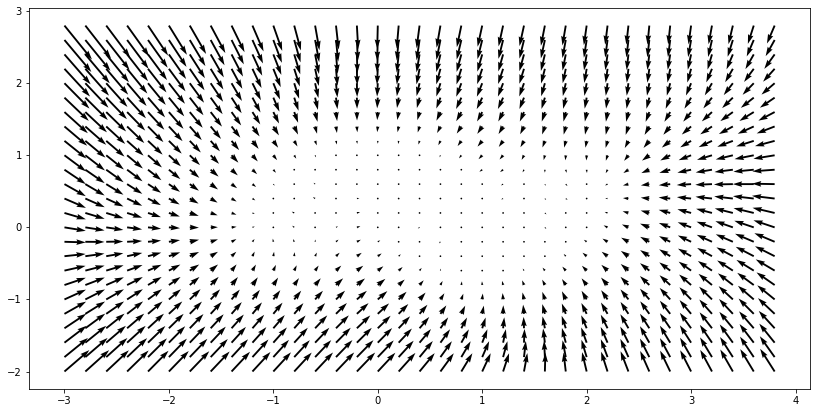

In [36]:
g = res.reshape([len(Y), len(X),2])
figure(figsize=(14,7))
quiver(X, Y, g[:,:,0], g[:,:,1])

In [156]:
def display_score_error_two_moons(true_score, estimated_scores, labels, distribution=None, dpi=100, n=28, is_amortized=True, is_reg=True, scale=1, offset=[0, 0]):
    #plt.figure(dpi=dpi)
    
    #c1 = [-3, -2]
    #c2 = [4, 3]
    scale = scale
    offset = jnp.array(offset)
    
    d_offset = jnp.array([.5, .25])
    c1 = scale * (jnp.array([-.7, -0.5])) + d_offset + offset
    c2 = scale * (jnp.array([.7, 0.5])) + d_offset + offset

    #X = np.arange(c1[0], c2[0], 0.1)
    #Y = np.arange(c1[1], c2[1], 0.1)
    n = 100
    X = np.linspace(c1[0], c2[0], int(n*7/5))
    Y = np.linspace(c1[1], c2[1], n)
    if distribution:
        _x, _y = jnp.meshgrid(jnp.arange(0, len(X), 1), jnp.arange(0, len(Y), 1))
        Z = jnp.stack(jnp.meshgrid(X, Y), axis=-1).reshape((-1, 2))
        S = distribution.log_prob(Z)
        dist = jnp.exp(S.reshape((len(Y), len(X))))
    
    points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
    true_s = true_score(points)
    true_s = true_s.reshape([len(Y), len(X),2])/jnp.linalg.norm(true_s)
    
    n_s = len(scores)
    estimated_vector_fileds = []
    errors = []

    for score in estimated_scores:
        if is_amortized:
            if is_reg:
                estimated_s, state = score(points, 0.0*jnp.ones((len(points),1)))
            else:
                estimated_s = score(points, 0.0*jnp.ones((len(points),1)))
        else:
            if is_reg:
                estimated_s, state = score(points)
            else:
                estimated_s = score(points)
        estimated_s = estimated_s.reshape([len(Y), len(X),2])/jnp.linalg.norm(estimated_s)
        
        estimated_vector_fileds.append(estimated_s)
        errors.append(jnp.linalg.norm(estimated_s - true_s, axis=2))
        
    v_min = jnp.min([jnp.min(e) for e in errors])
    v_max = jnp.max([jnp.max(e) for e in errors])

    for i in range(n_s):
        plt.subplot(n_s, 2, 2*i+1)
        plt.imshow(errors[i], origin='lower', vmin=v_min, vmax=v_max)
        plt.axis('off')
        
        plt.colorbar()
        if distribution:
            plt.contour(_x, _y, dist, levels=[1], colors='white')
        plt.title('Score error ({}), avg={:.2e}'.format(labels[i], jnp.mean(errors[i])), fontsize=9)
        
        plt.subplot(n_s, 2, 2*i+2)
        
        g = estimated_vector_fileds[i]
        plt.quiver(X[::4], Y[::4], g[::4,::4,0], g[::4,::4,1])
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('error_comparison.png')    
    

In [157]:
scores = [dae_score, score_sn]
labels = ['DAE', 'SN DAE']

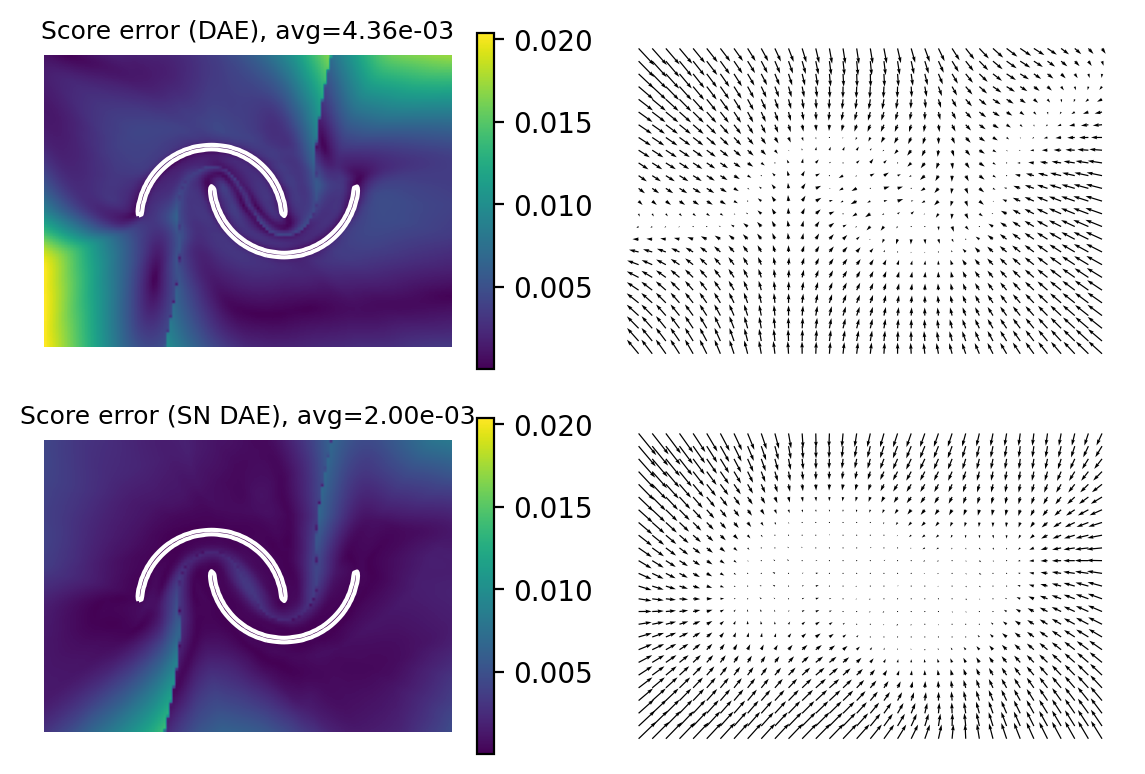

In [158]:
plt.figure(dpi=200)
scale = 4
offset = [0, 0]
display_score_error_two_moons(true_score, scores, labels, distribution=two_moons, is_amortized=True, is_reg=True, scale=scale, offset=offset)

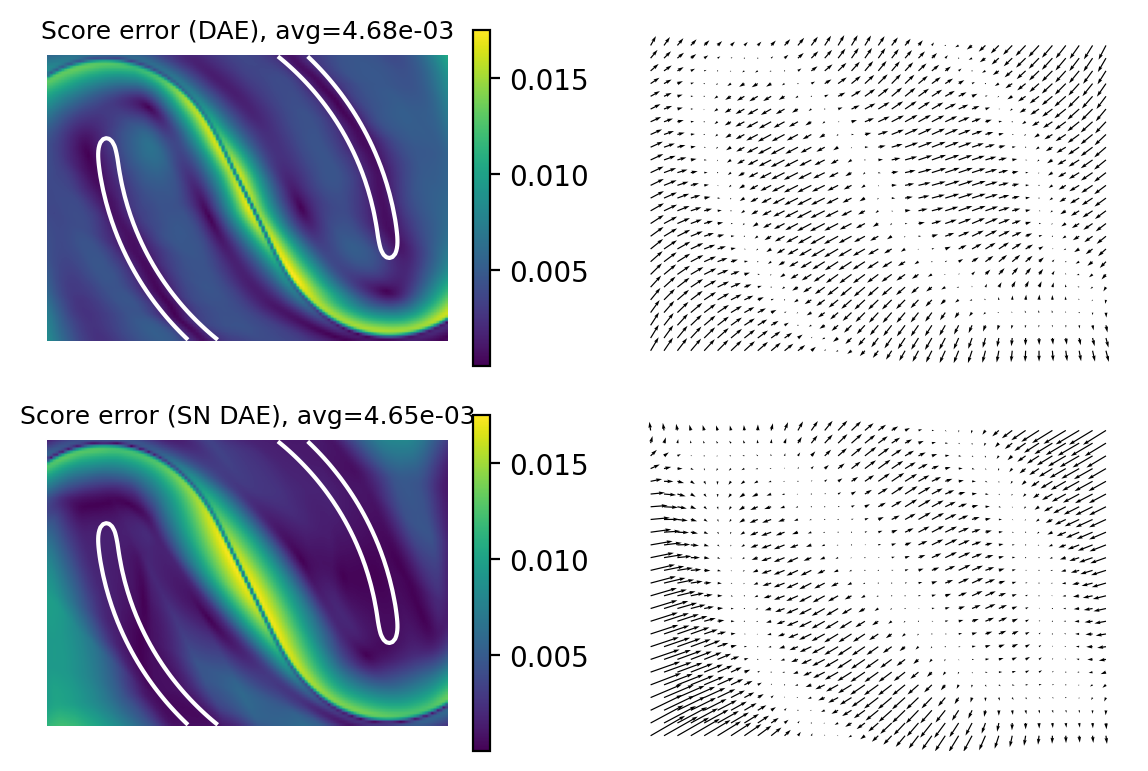

In [159]:
plt.figure(dpi=200)
scale = 1
offset = [0, 0]
display_score_error_two_moons(true_score, scores, labels, distribution=two_moons, is_amortized=True, is_reg=True, scale=scale, offset=offset)